<a href="https://colab.research.google.com/github/aribamazharam/efficient-net/blob/main/StickBlur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install timm
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import timm
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import seaborn as sn
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.9 MB/s eta 0:00:00


In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Set random seed for reproducibility
torch.manual_seed(42)

In [4]:
# Define data transforms
data_transforms = transforms.Compose([
    transforms.Resize((224 , 224)),  # EfficientNet-B6 input size is (528, 528)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

In [5]:
# Set path to your train, val, and test directories
data_dir = '/content/drive/MyDrive/Golf_Stick_Dataset'
# Create train, val, and test datasets
train_dataset = ImageFolder(os.path.join(data_dir, '/content/drive/MyDrive/Golf_Stick_Dataset/train'), transform=data_transforms)
val_dataset = ImageFolder(os.path.join(data_dir, '/content/drive/MyDrive/Golf_Stick_Dataset/valid'), transform=data_transforms)
test_dataset = ImageFolder(os.path.join(data_dir, '/content/drive/MyDrive/Golf_Stick_Dataset/test'), transform=data_transforms)
# Create train, val, and test data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
# Create model
num_classes = len(train_dataset.classes)
model = timm.create_model('efficientnet_b0', pretrained=True)

In [8]:
#Training loop
num_epochs = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move the model to the same device as the input data
model.to(device)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        train_correct += torch.sum(preds == labels.data)
    train_loss /= len(train_dataset)
    train_accuracy = train_correct.double() / len(train_dataset)
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            val_correct += torch.sum(preds == labels.data)
    val_loss /= len(val_dataset)
    val_accuracy = val_correct.double() / len(val_dataset)
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'train_accuracy': train_accuracy,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy
    }
    torch.save(checkpoint, f'checkpoint_epoch_{epoch + 1}.pth')
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy.cpu().numpy())
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy.cpu().numpy())
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/10], Train Loss: 2.9751, Train Accuracy: 0.5604, Val Loss: 0.2685, Val Accuracy: 0.9333


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2/10], Train Loss: 0.1668, Train Accuracy: 0.9667, Val Loss: 0.2256, Val Accuracy: 0.9333


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [3/10], Train Loss: 0.0925, Train Accuracy: 0.9729, Val Loss: 0.3433, Val Accuracy: 0.9500


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [4/10], Train Loss: 0.0174, Train Accuracy: 0.9979, Val Loss: 0.3969, Val Accuracy: 0.9500


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [5/10], Train Loss: 0.0082, Train Accuracy: 1.0000, Val Loss: 0.3932, Val Accuracy: 0.9500


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [6/10], Train Loss: 0.0032, Train Accuracy: 1.0000, Val Loss: 0.4070, Val Accuracy: 0.9500


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [7/10], Train Loss: 0.0038, Train Accuracy: 1.0000, Val Loss: 0.4531, Val Accuracy: 0.9500


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [8/10], Train Loss: 0.0177, Train Accuracy: 0.9979, Val Loss: 0.4229, Val Accuracy: 0.9500


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [9/10], Train Loss: 0.0025, Train Accuracy: 1.0000, Val Loss: 0.3344, Val Accuracy: 0.9500


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [10/10], Train Loss: 0.0007, Train Accuracy: 1.0000, Val Loss: 0.3397, Val Accuracy: 0.9500


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy: 0.9355


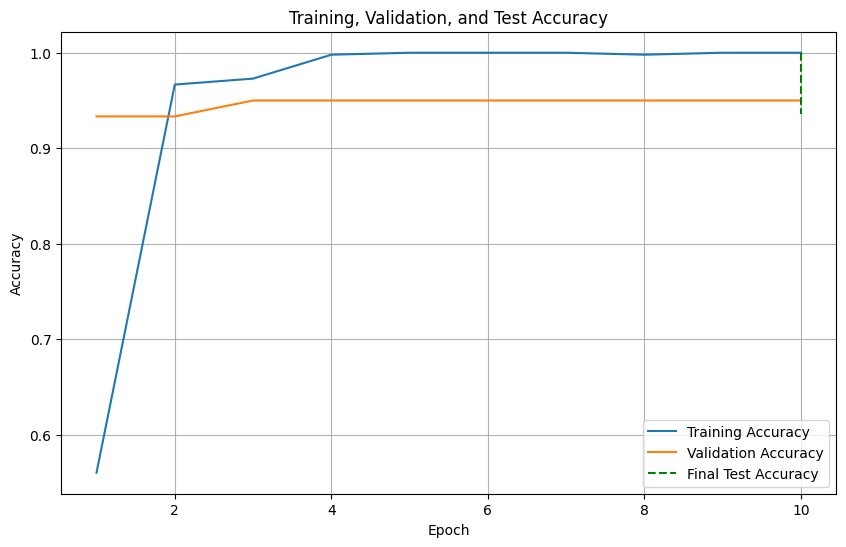

In [9]:
# Testing phase
model.eval()
test_correct = 0
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        test_correct += torch.sum(preds == labels.data)
test_accuracy = test_correct.double() / len(test_dataset)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Plot Training, Validation, and Test Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.plot([num_epochs] * 2, [train_accuracies[-1], test_accuracy.cpu().numpy()], 'g--', label='Final Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
%cd /content/drive/MyDrive/path_to_directory

In [ ]:
# Assuming you have a new unseen dataset stored in 'unseen_dir'
unseen_dataset = ImageFolder(os.path.join(data_dir, 'unseen'), transform=data_transforms)
unseen_loader = DataLoader(unseen_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

model.eval()
unseen_correct = 0
with torch.no_grad():
    for images, labels in tqdm(unseen_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        unseen_correct += torch.sum(preds == labels.data)
unseen_accuracy = unseen_correct.double() / len(unseen_dataset)
print(f'Unseen Dataset Accuracy: {unseen_accuracy:.4f}')

In [ ]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()